#### Load and Prepare Data

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import tkinter as tk
from PIL import Image, ImageGrab, ImageTk, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import os


print(torch.__version__)

2.0.1


In [2]:
# Setup the data transformation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5, fill=(255, 255, 255)),
    transforms.Resize((256,256)), # Resize to the desired size
    transforms.RandomCrop(256), # Optional: Apply random crop if needed
    transforms.ToTensor()
])


data_path = "images"
datasets = torchvision.datasets.ImageFolder(root = data_path, transform = transform)

data_loader = torch.utils.data.DataLoader(datasets, batch_size= 32, shuffle = True)

Label: Triangle


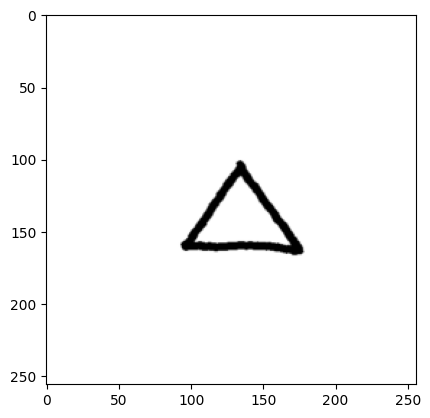

Label: Square


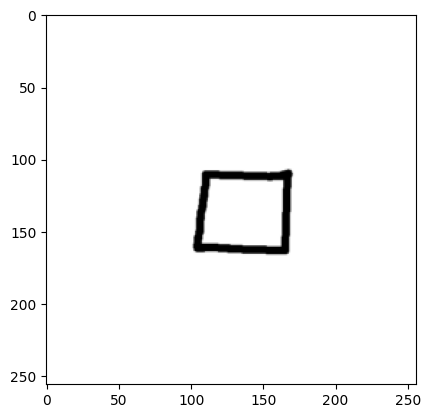

Label: Triangle


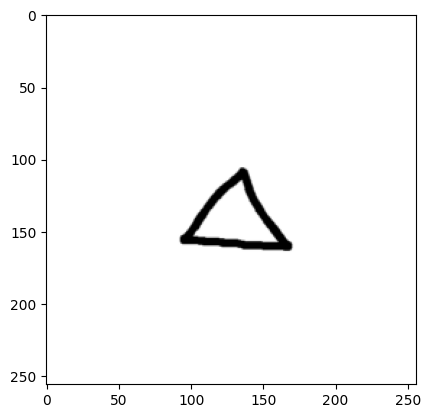

Label: Triangle


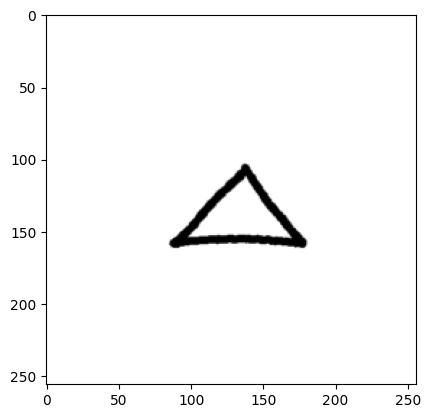

Label: Triangle


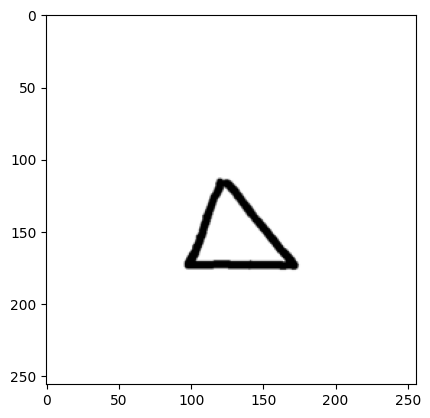

Label: Square


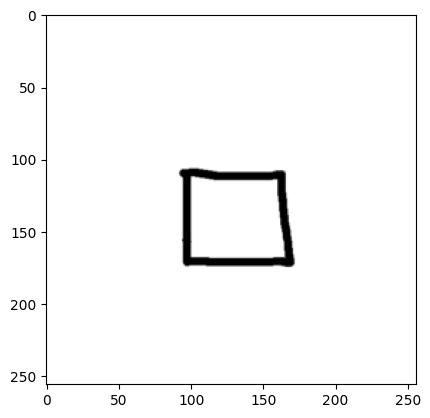

Label: Square


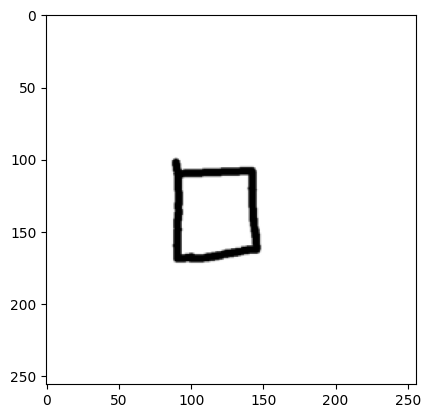

Label: Square


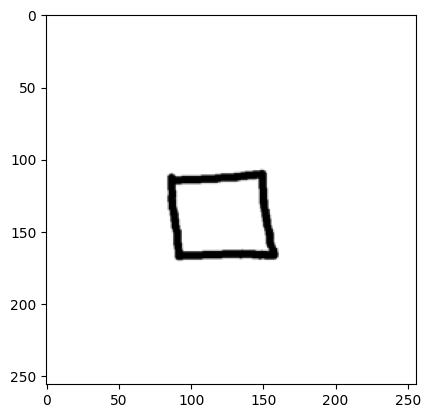

Label: Square


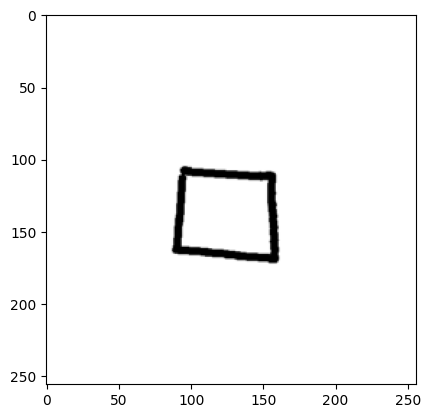

Label: Triangle


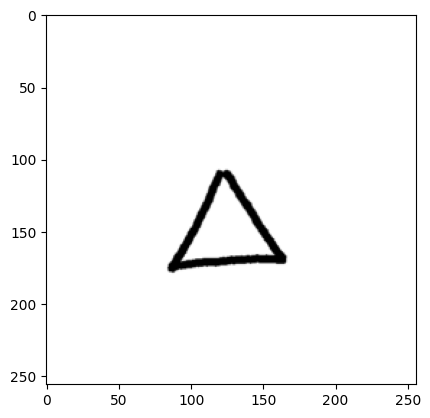

In [3]:
# Make sure images are correct
def imshow(img_tensor):
    # Convert from tensor to numpy array
    np_img = img_tensor.numpy()
    # Change from (C, H, W) to (H, W, C) for visualization
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

# Get a batch of images and labels
data_iter = iter(data_loader)
images, labels = next(data_iter)

# Visualize images in the batch
for i in range(images.size(0)):
    print(f"Label: {datasets.classes[labels[i]]}")
    imshow(images[i])

In [4]:
# Data Augmentation
img_num = 0

# Base directory for augmented images
augmented_base_dir = "augmented_images"

# Create a base directory for the augmented images if not exists
if not os.path.exists(augmented_base_dir):
    os.mkdir(augmented_base_dir)

for _ in range(100):
    for img, label in datasets:
        
        # Get the folder name from the label
        folder_name = [folder for folder, idx in datasets.class_to_idx.items() if idx == label][0]
        
        # Create a directory for each class inside augmented_images if it does not exist
        augmented_class_path = os.path.join("augmented_images", folder_name)
        if not os.path.exists(augmented_class_path):
            os.makedirs(augmented_class_path)
        
        # Save the augmented image
        torchvision.utils.save_image(img, os.path.join(augmented_class_path, 'img'+str(img_num)+'.png'))
        img_num += 1


In [5]:
# Update the working datasets
augmented_data_path = "augmented_images"
augmented_datasets = torchvision.datasets.ImageFolder(root = augmented_data_path, transform = transform)

augmented_data_loader = torch.utils.data.DataLoader(datasets, batch_size= 32, shuffle = True)

# Display class names and index labels for debug
print("Class names: ", augmented_datasets.classes)
print("Class index mapping:", augmented_datasets.class_to_idx)

Class names:  ['Square', 'Triangle']
Class index mapping: {'Square': 0, 'Triangle': 1}


Total Images: 1000
Training Images: 800
Validation Images: 200


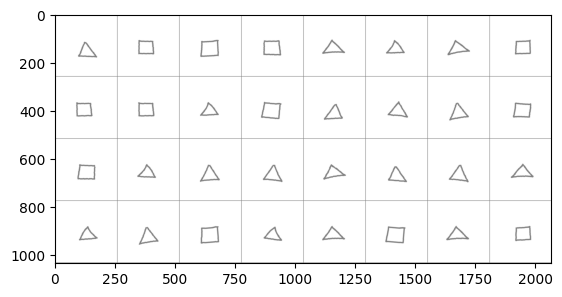

Labels: tensor([1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 0])


In [6]:
# Split dataset into training and validation sets
train_size = int(0.8 * len(augmented_datasets))
valid_size = len(augmented_datasets) - train_size
train_dataset, valid_dataset = torch.utils.data.random_split(augmented_datasets, [train_size, valid_size])

print(f"Total Images: {len(augmented_datasets)}")
print(f"Training Images: {len(train_dataset)}")
print(f"Validation Images: {len(valid_dataset)}")

# Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= 32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size= 32, shuffle = False)

# Function to unnormalize and plot image
def imshow(img):
    img = img / 2 + 0.5  # Assuming normalization was mean=0.5 and std=0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get random batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.__next__()

# Show images
imshow(torchvision.utils.make_grid(images))
print("Labels:", labels)

#### Define the Model

In [9]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

model = models.resnet50(weights=True)

/Users/philiphan/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Change the number of outputs
num_classes = 2
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

#### Specify Loss Function and Optimizer

In [11]:
lossf = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

#### Train the Model

In [16]:
epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0

    for inputs, labels in augmented_data_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = lossf(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        correct_train += torch.sum(preds == labels.data).item()

    train_loss = train_loss / len(augmented_data_loader.dataset)
    train_accuracy = correct_train / len(augmented_data_loader.dataset)

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = lossf(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            correct_val += torch.sum(preds == labels.data).item()

    val_loss = val_loss / len(valid_loader.dataset)
    val_accuracy = correct_val / len(valid_loader.dataset)

    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print('-' * 60)

Epoch 1/10
Training Loss: 0.0328, Training Accuracy: 1.0000
Validation Loss: 0.1553, Validation Accuracy: 0.9700
------------------------------------------------------------
Epoch 2/10
Training Loss: 0.0192, Training Accuracy: 1.0000
Validation Loss: 0.0191, Validation Accuracy: 1.0000
------------------------------------------------------------
Epoch 3/10
Training Loss: 0.0053, Training Accuracy: 1.0000
Validation Loss: 12.6941, Validation Accuracy: 0.4500
------------------------------------------------------------
Epoch 4/10
Training Loss: 0.0067, Training Accuracy: 1.0000
Validation Loss: 29.0512, Validation Accuracy: 0.4500
------------------------------------------------------------
Epoch 5/10
Training Loss: 0.0094, Training Accuracy: 1.0000
Validation Loss: 25.0493, Validation Accuracy: 0.4500
------------------------------------------------------------
Epoch 6/10
Training Loss: 0.0048, Training Accuracy: 1.0000
Validation Loss: 13.5180, Validation Accuracy: 0.4500
-------------

#### Evaluate the Model

In [17]:
torch.save(model, "models/model1.pth")

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in valid_loader:
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Validation Accuracy: 90.50%
Test Accuracy: 92.62%


#### Live Prediction

In [18]:
# Assuming the SimpleCNN class definition is already present
model = torch.load('models/model1.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
# Ensure the model is in evaluation mode
model.eval()

# Transform function
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to the input size your model expects
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Standard normalization values
])

In [20]:
class DrawingApp:
    def __init__(self, root):
        self.root = root
        self.root.title("Prediction Board")

        self.canvas = tk.Canvas(root, bg="white", width=500, height=500)
        self.canvas.pack(pady=20)
        
        self.canvas.bind("<B1-Motion>", self.paint)
        self.canvas.bind("<ButtonRelease-1>", self.reset_last_coordinates)

        self.predict_button = tk.Button(root, text="Predict", command=self.predict)
        self.predict_button.pack(pady=20)

        self.clear_button = tk.Button(root, text="Clear", command=self.clear_screen)
        self.clear_button.pack(pady=20)

        self.result_label = tk.Label(root, text="", font=("Arial", 12))
        self.result_label.pack(pady=20)

        self.last_x, self.last_y = None, None

    def paint(self, event):
        x, y = event.x, event.y
        if self.last_x and self.last_y:
            self.canvas.create_line((self.last_x, self.last_y, x, y), width=10, fill='black', capstyle=tk.ROUND, smooth=tk.TRUE)
        self.last_x, self.last_y = x, y

    def reset_last_coordinates(self, event):  
        self.last_x, self.last_y = None, None

    def clear_screen(self):
        self.canvas.delete("all")
        self.result_label.config(text="")  # Clear the result label

    def predict(self):
        # Capture the canvas content and convert it to a PIL Image
        x = self.root.winfo_rootx() + self.canvas.winfo_x()
        y = self.root.winfo_rooty() + self.canvas.winfo_y()
        x1 = x + self.canvas.winfo_width()
        y1 = y + self.canvas.winfo_height()

        img = ImageGrab.grab(bbox=(x, y, x1, y1)).convert('RGB')
        img = img.resize((256, 256))  # Ensure the image is resized to 256x256
        
        # Transform the image and make a prediction
        img_tensor = transform(img).unsqueeze(0)

        
        with torch.no_grad():
            output = model(img_tensor)
            prediction = output.argmax(dim=1).item()
        
        predicted_class = augmented_datasets.classes[prediction]
        probability = F.softmax(output, dim=1)
        confidence = probability[0][prediction].item()
        
        # Display the prediction in the label widget
        self.result_label.config(text=f"Predicted Class: {predicted_class}\nConfidence: {confidence * 100:.2f}")


In [21]:
if __name__ == "__main__":
    root = tk.Tk()
    app = DrawingApp(root)
    root.mainloop()

Image tensor size: torch.Size([1, 3, 256, 256])
Hello
Image tensor size: torch.Size([1, 3, 256, 256])
Hello
Image tensor size: torch.Size([1, 3, 256, 256])
Hello
Image tensor size: torch.Size([1, 3, 256, 256])
Hello
Image tensor size: torch.Size([1, 3, 256, 256])
Hello
Image tensor size: torch.Size([1, 3, 256, 256])
Hello
Image tensor size: torch.Size([1, 3, 256, 256])
Hello
Image tensor size: torch.Size([1, 3, 256, 256])
Hello
Image tensor size: torch.Size([1, 3, 256, 256])
Hello
Image tensor size: torch.Size([1, 3, 256, 256])
Hello
Image tensor size: torch.Size([1, 3, 256, 256])
Hello
Image tensor size: torch.Size([1, 3, 256, 256])
Hello
Image tensor size: torch.Size([1, 3, 256, 256])
Hello


: 